# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
path = '/content/bikes_rent.csv'

In [3]:
data = pd.read_csv(path)

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [4]:
df = pd.read_csv(path)
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

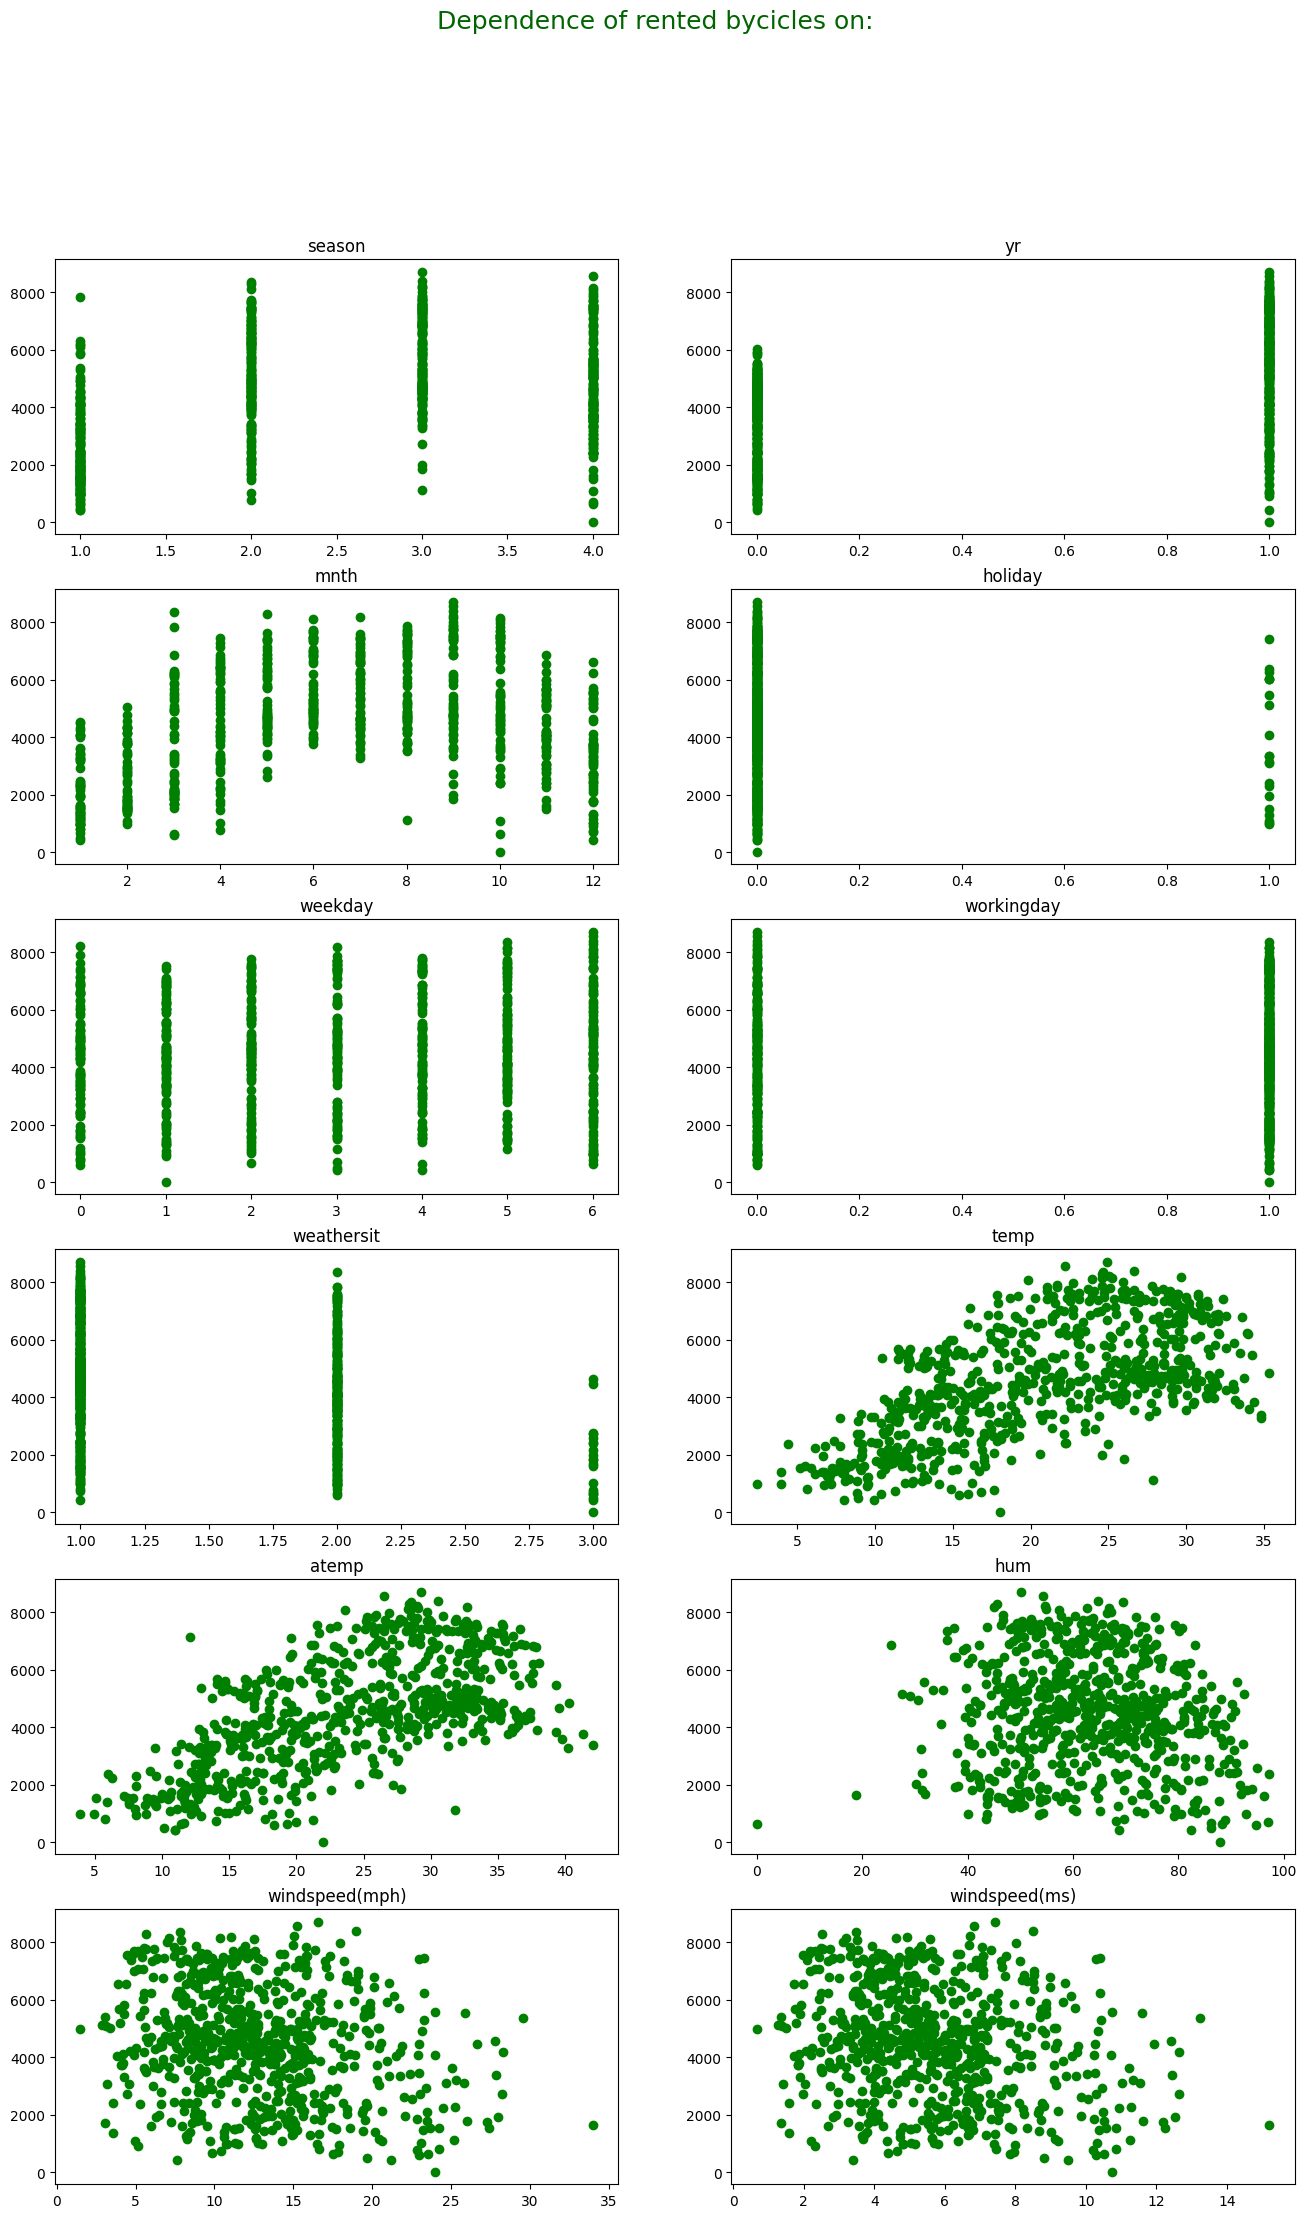

In [7]:
numbers = [(x, y) for x in range(6) for y in range(2)]
fig, axs = plt.subplots(6, 2, figsize=(16, 25))

for i in enumerate(df.columns[0:12]):
  axs[numbers[i[0]]].scatter(df[i[1]], df['cnt'], c='green', label=i[1])
  axs[numbers[i[0]]].set_title(i[1])

fig.suptitle('Dependence of rented bycicles on:', fontsize=18, color='darkgreen')

plt.show()

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно

1. According to the data, the low season for rentals is in Jan-Feb, with an average of around 4-4.5k per month. From March until Dec, rentals remain in the same range of 7-8k per month, with the highest rentals falling on 9-10(Sep-Oct), reaching above 8-8.5k. In other words, Sep-Oct are the peak months for rentals, while the rest of the year shows a consistent demand in the range of 7-8k per month.

2. One of the key factos is the season. It is shown that 1.0, which is assumably the end of winter, Jan-Feb, is the lowest. And the highest falls in 2.0-4.0, which is spring, summer and the beginning of winter. The factos of temp and atemp affect on this too. It's possible that warmer tempt during the spring and summer months and the start of winter may make it more pleasant to ride a bike and thus increase the number of rentals. Converserly, colder temperatures during the end of winter may discourage people from renting bikes.

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [8]:
df.corrwith(df['cnt'], method='pearson').round(2)

season            0.41
yr                0.57
mnth              0.28
holiday          -0.07
weekday           0.07
workingday        0.06
weathersit       -0.30
temp              0.63
atemp             0.63
hum              -0.10
windspeed(mph)   -0.23
windspeed(ms)    -0.23
cnt               1.00
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [9]:
df[['temp','atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr().round(4)

#double [] to accesss multiple columns in DataFrame

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.0000,0.9917,0.1270,-0.1579,-0.1579,0.6275
atemp,0.9917,1.0000,0.1400,-0.1836,-0.1836,0.6311
hum,0.1270,0.1400,1.0000,-0.2485,-0.2485,-0.1007
windspeed(mph),-0.1579,-0.1836,-0.2485,1.0000,1.0000,-0.2345
windspeed(ms),-0.1579,-0.1836,-0.2485,1.0000,1.0000,-0.2345
cnt,0.6275,0.6311,-0.1007,-0.2345,-0.2345,1.0000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [10]:
df.mean().round(3)

season               2.497
yr                   0.501
mnth                 6.520
holiday              0.029
weekday              2.997
workingday           0.684
weathersit           1.395
temp                20.311
atemp               23.718
hum                 62.789
windspeed(mph)      12.763
windspeed(ms)        5.705
cnt               4504.349
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [11]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [12]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [13]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [14]:
clf = LinearRegression()
clf.fit(X, y)
list(zip(df.columns, clf.coef_.round(2)))

[('season', 570.86),
 ('yr', 1021.97),
 ('mnth', -141.3),
 ('holiday', -86.76),
 ('weekday', 137.23),
 ('workingday', 56.39),
 ('weathersit', -330.23),
 ('temp', 367.48),
 ('atemp', 585.55),
 ('hum', -145.61),
 ('windspeed(mph)', 12457138390688.88),
 ('windspeed(ms)', -12457138390887.34)]

Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [ ]:
from sklearn import linear_model
reg = linear_model.Lasso().fit(X, y)
list(zip(df.columns, reg.coef_.round(2)))

[('season', 560.24),
 ('yr', 1019.46),
 ('mnth', -128.73),
 ('holiday', -86.15),
 ('weekday', 137.35),
 ('workingday', 55.21),
 ('weathersit', -332.37),
 ('temp', 376.36),
 ('atemp', 576.53),
 ('hum', -144.13),
 ('windspeed(mph)', -197.14),
 ('windspeed(ms)', -0.0)]

Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [15]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X, y)
list(zip(df.columns, model.coef_.round(2)))

[('season', 563.06),
 ('yr', 1018.95),
 ('mnth', -131.87),
 ('holiday', -86.75),
 ('weekday', 138.01),
 ('workingday', 55.9),
 ('weathersit', -332.35),
 ('temp', 386.46),
 ('atemp', 566.35),
 ('hum', -145.07),
 ('windspeed(mph)', -99.26),
 ('windspeed(ms)', -99.26)]

### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [16]:
from sklearn.linear_model import Lasso, Ridge

alphas = np.arange(1, 500, 50)

coefs_lasso = [] 
coefs_ridge = []

for alpha in alphas:
    # Lasso
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)

    # Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проанализируйте динамику весов при увеличении параметра регуляризации:

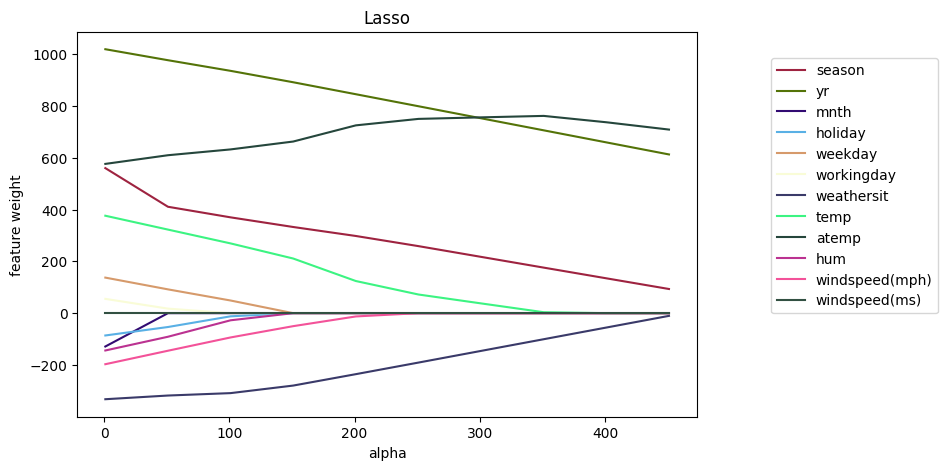

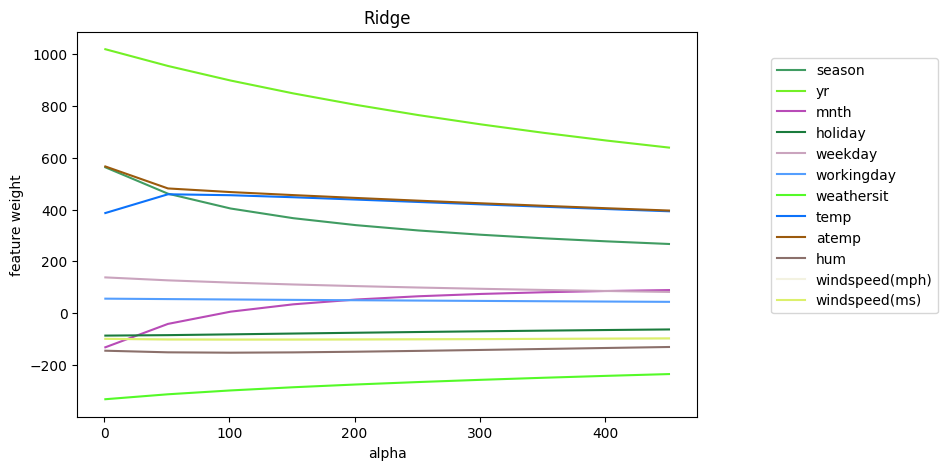

In [17]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

1. Lasso
2. The weight will become equal to "0".
*(Alpha represents the strength of the regularization term. A higher alpha value results in a stronger penalty, and therefore fewer features being used in the model. As the value of alpha increases, the model complexity reduces. Though higher values of alpha reduce overfitting, significantly high values can cause underfitting as well. Thus alpha should be chosen wisely. A widely accepted technique is cross-validation, i.e., the value of alpha is iterated over a range of values, and the one giving a higher cross-validation score is chosen.)*

3. Lasso will exclude, but Ridge will normalize it and make weights equal. 

4. Based on the previous question and asnwer, Lasso is the most suitable. 

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [19]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    # x = map(lambda e: e[0], data) - doesn't work
    # y = map(lambda e: e[1], data)

    # x = list(map(lambda e: e[0], data)) - even converting to a list doesn't work

    x = data[0]
    y = data[1]

    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()


Alpha: 1

Weight coefficients:
('season', 560.0)
('yr', 1019.0)
('mnth', -129.0)
('holiday', -86.0)
('weekday', 137.0)
('workingday', 55.0)
('weathersit', -332.0)
('temp', 376.0)
('atemp', 577.0)
('hum', -144.0)
('windspeed(mph)', -197.0)
('windspeed(ms)', -0.0)


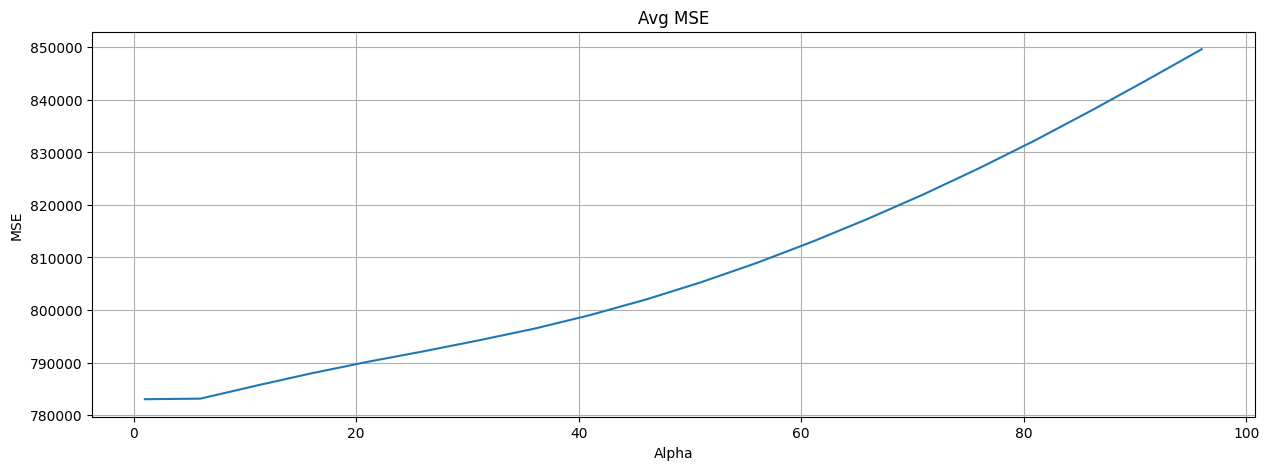

In [20]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas).fit(X, y)

print('\nAlpha: ' + str(regressor.alpha_))

print('\nWeight coefficients:')
for item in list(zip(df.columns[:-1], regressor.coef_.round())):
  print (item)

mse_mean = (regressor.alphas_, np.mean(regressor.mse_path_, axis=1))
title = 'Avg MSE'
xlabel = 'Alpha'
ylabel = 'MSE'
create_plot(mse_mean, title, xlabel, ylabel)

# #Plot MSE(alpha)
# plt.title('Avg MSE')
# plt.plot(regressor.alphas_, np.mean(regressor.mse_path_, axis=1))
# plt.xlabel('Alpha')
# plt.ylabel('MSE')
# plt.grid()
# plt.show()

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


In [21]:
mse = regressor.mse_path_

Alpha = [96 91 86 81 76 71 66 61 56 51 46 41 36 31 26 21 16 11  6  1]


 Column 1, alpha = 11


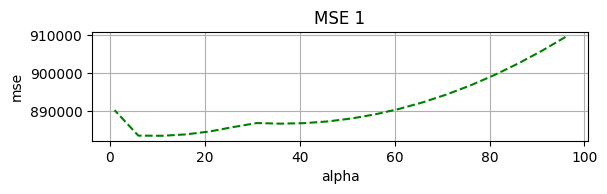


 Column 2, alpha = 1


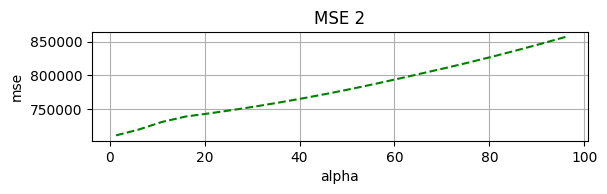


 Column 3, alpha = 26


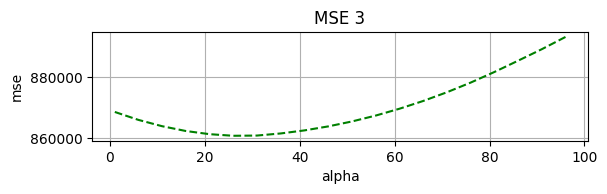

In [22]:
print(f'Alpha = {regressor.alphas_}\n')

for i in range(3):
  i+=1
  print(f'\n Column {i}, alpha = {regressor.alphas_[mse[:,i].argmin()]}')
  plt.subplot(3, 1, i)
  plt.plot(regressor.alphas_, mse[:,i], linestyle='--', color='g')
  plt.title(f"MSE {i}")
  plt.xlabel('alpha')
  plt.ylabel('mse')
  plt.grid()
  plt.show()

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

__Ответ:__

In [ ]:
list_att = list(zip(df.columns, regressor.coef_.round()))
max_coef = list_att[0], list_att[1], list_att[7], list_att[8]
max_coef

(('season', 560.0), ('yr', 1019.0), ('temp', 376.0), ('atemp', 577.0))

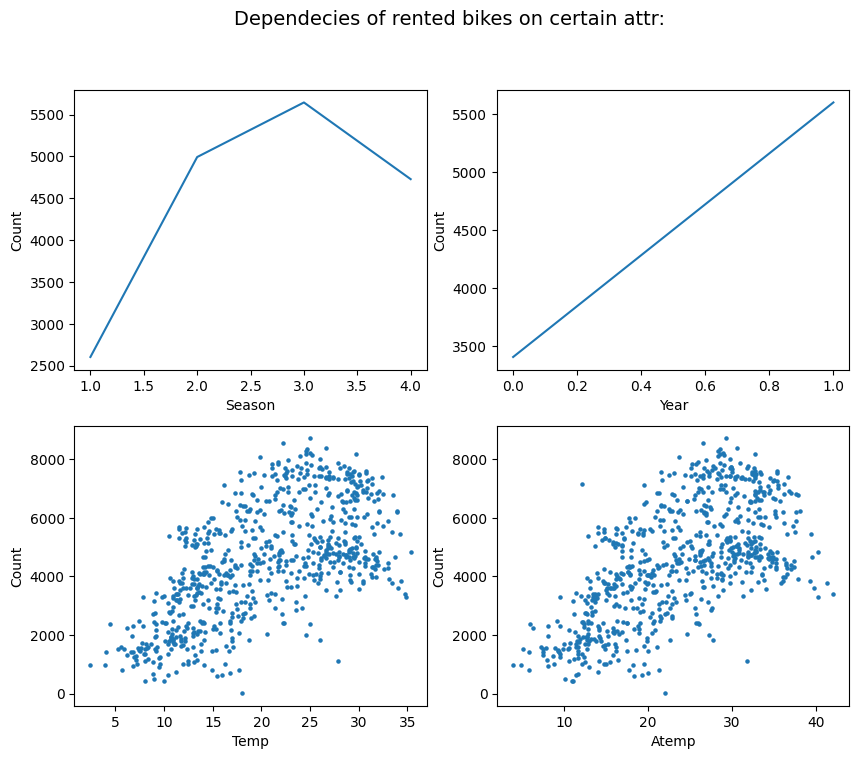

In [ ]:
season = df.groupby(['season'])[['cnt']].agg(['mean'])
year = df.groupby(['yr'])[['cnt']].agg(['mean'])

season_plt = season[('cnt', 'mean')]
year_plt = year[('cnt', 'mean')]

fig, axs = plt.subplots(2, 2, figsize=(10,8))

axs[0, 0].plot(df['season'].unique(), season_plt)
# axs[0, 0].scatter(df['season'], df.cnt)
axs[0, 0].set_xlabel('Season')
axs[0, 0].set_ylabel('Count')

axs[0, 1].plot(df['yr'].unique(), year_plt)
# axs[0, 1].scatter(df['yr'], df.cnt)
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Count')

axs[1, 0].scatter(df['temp'], df.cnt, s=5)
axs[1, 0].set_xlabel('Temp')
axs[1, 0].set_ylabel('Count')

axs[1, 1].scatter(df['atemp'], df.cnt, s=5)
axs[1, 1].set_xlabel('Atemp')
axs[1, 1].set_ylabel('Count')

fig.suptitle('Dependecies of rented bikes on certain attr:', fontsize=14)

plt.show()

Seasonality has a clear affect or dependency on the rentals along with the temp and atemp. With regards to the year, we have only two years of data and it is not enough to justify the assumption. 

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

In [ ]:
list_att = list(zip(df.columns, regressor.coef_.round()))
low_coef = list_att[2], list_att[6], list_att[9]
low_coef

(('mnth', -129.0), ('weathersit', -332.0), ('hum', -144.0))

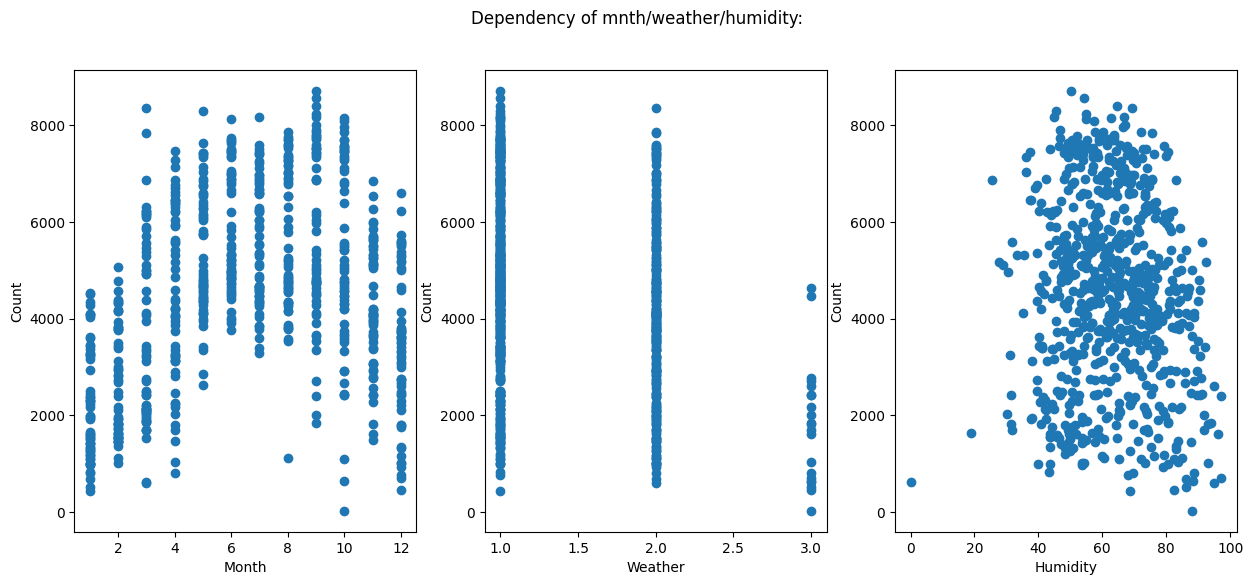

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

axs[0].scatter(df['mnth'], df.cnt)
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Count')

axs[1].scatter(df['weathersit'], df.cnt)
axs[1].set_xlabel('Weather')
axs[1].set_ylabel('Count')

axs[2].scatter(df['hum'], df.cnt)
axs[2].set_xlabel('Humidity')
axs[2].set_ylabel('Count')

fig.suptitle('Dependency of mnth/weather/humidity:', fontsize=12)

plt.show()

It seems like all three attributes affect the number of rentals. January and February have the lowest rental counts, the weather significantly decreases rentals in the third quarter, and humidity below 40 leads to lower rentals.

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [ ]:
list_att = list(zip(df.columns, regressor.coef_.round()))
coef_0 = list_att[-1]
coef_0

('windspeed(ms)', -0.0)

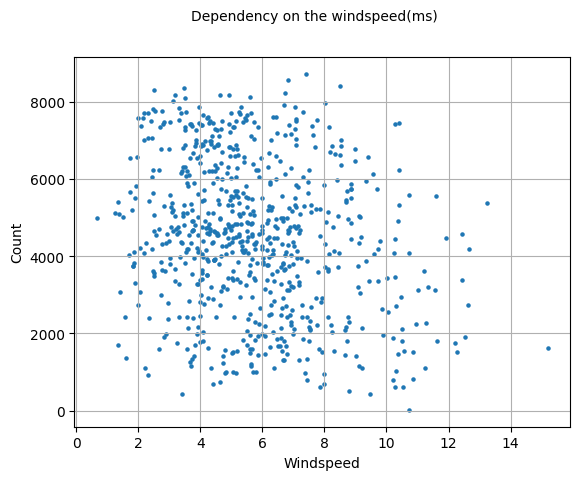

In [ ]:
fig, axs = plt.subplots()

axs.scatter(df['windspeed(ms)'], df.cnt, s=5)
axs.set_xlabel('Windspeed')
axs.set_ylabel('Count')

fig.suptitle('Dependency on the windspeed(ms)', fontsize=10)

plt.grid()
plt.show()

Based on the given plot, it seems that there is a decrease in the number of rented bikes starting around 11. Therefore, it is reasonable to conclude that there is a dependency between the weather and the number of rented bikes.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.